Inspiration from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [1]:
from IPython.display import Image as display_image
from google.colab import drive
import os
import random
import PIL
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
!git clone https://github.com/rbarman/AnimeGANs

Cloning into 'AnimeGANs'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 21 (delta 7), reused 11 (delta 3), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [3]:
%cd AnimeGANs/

/content/AnimeGANs


In [4]:
!ls

Anime_face_GAN.ipynb  device_utils.py  my_modules.py  README.md


In [21]:
from my_modules import Discriminator, Generator
from device_utils import get_default_device, DeviceDataLoader, to_device

**Get images**
- I saved results from https://github.com/bchao1/Anime-Face-Dataset to google drive
- Could get more samples using the haar cascade from https://github.com/nagadomi/animeface-2009

In [6]:
drive.mount('/content/drive')
!tar -xvzf  /content/drive/My\ Drive/Anime-Faces.tgz

Streaming output truncated to the last 5000 lines.
cropped/20131_2007.jpg
cropped/47683_2014.jpg
cropped/7328_2004.jpg
cropped/53270_2016.jpg
cropped/5206_2003.jpg
cropped/18522_2007.jpg
cropped/45972_2014.jpg
cropped/57454_2017.jpg
cropped/9157_2004.jpg
cropped/506_2000.jpg
cropped/18744_2007.jpg
cropped/57632_2017.jpg
cropped/9331_2004.jpg
cropped/760_2000.jpg
cropped/20357_2007.jpg
cropped/5060_2003.jpg
cropped/53016_2016.jpg
cropped/51495_2015.jpg
cropped/37388_2012.jpg
cropped/45784_2014.jpg
cropped/62002_2019.jpg
cropped/51805_2015.jpg
cropped/3525_2002.jpg
cropped/47875_2014.jpg
cropped/58685_2017.jpg
cropped/27363_2009.jpg
cropped/44703_2013.jpg
cropped/23547_2008.jpg
cropped/32086_2010.jpg
cropped/14016_2006.jpg
cropped/34953_2011.jpg
cropped/41933_2013.jpg
cropped/40127_2012.jpg
cropped/48452_2014.jpg
cropped/33892_2011.jpg
cropped/11554_2005.jpg
cropped/16377_2006.jpg
cropped/21626_2008.jpg
cropped/33402_2011.jpg
cropped/25002_2009.jpg
cropped/33664_2011.jpg
cropped/60749_20

In [7]:
def view_rand_img(img_dir = '/content/AnimeGANs/cropped/'):
  imgs = os.listdir(img_dir)
  img_path = img_dir  + random.choice(imgs)
  print(img_path)
  return display_image(img_path)

/content/AnimeGANs/cropped/28189_2009.jpg


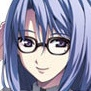

In [8]:
view_rand_img()

In [9]:
# There are some invalid images...
display_image('/content/AnimeGANs/cropped/44478_2013.jpg')

In [10]:
for img_name in os.listdir('/content/AnimeGANs/cropped/'):
  img_path = f'/content/AnimeGANs/cropped/{img_name}'
  try:
    _ = PIL.Image.open(img_path)
  except PIL.UnidentifiedImageError:
    print(f'{img_path} is an invalid image')
    os.remove(img_path)

/content/AnimeGANs/cropped/24884_2009.jpg is an invalid image
/content/AnimeGANs/cropped/8565_2004.jpg is an invalid image
/content/AnimeGANs/cropped/6955_2003.jpg is an invalid image
/content/AnimeGANs/cropped/6339_2003.jpg is an invalid image
/content/AnimeGANs/cropped/54405_2016.jpg is an invalid image
/content/AnimeGANs/cropped/58070_2017.jpg is an invalid image
/content/AnimeGANs/cropped/46234_2014.jpg is an invalid image
/content/AnimeGANs/cropped/61050_2018.jpg is an invalid image
/content/AnimeGANs/cropped/6188_2003.jpg is an invalid image
/content/AnimeGANs/cropped/38922_2012.jpg is an invalid image
/content/AnimeGANs/cropped/27828_2009.jpg is an invalid image
/content/AnimeGANs/cropped/55062_2016.jpg is an invalid image
/content/AnimeGANs/cropped/55501_2016.jpg is an invalid image
/content/AnimeGANs/cropped/5964_2003.jpg is an invalid image
/content/AnimeGANs/cropped/20561_2008.jpg is an invalid image
/content/AnimeGANs/cropped/24453_2009.jpg is an invalid image
/content/Anim

Create DataLoaders

In [11]:
ROOT_IMAGE_DIR = '/content/'
IMAGE_SIZE = 64
BATCH_SIZE = 128
NUM_CHANNELS = 3
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [12]:
train_ds = ImageFolder(ROOT_IMAGE_DIR, transform=T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(*STATS)]))

In [13]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3)

In [14]:
def show_batch(dl):
  images, _ = next(iter(dl))
  plt.figure(figsize=(8,8))
  plt.axis("off")
  # permuting because matplotlib needs (x,y, num channels) while tensor is (num channels, x, y)
  plt.imshow(make_grid(images.detach()[0:64],padding=2,normalize=True,).permute(1,2,0));

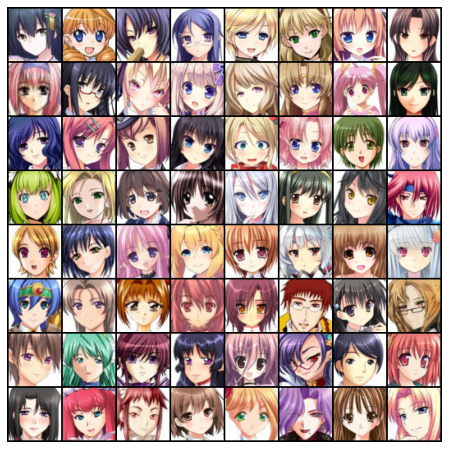

In [15]:
show_batch(train_dl)

In [16]:
device = get_default_device()
device

device(type='cpu')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)

In [19]:
images,labels = next(iter(train_dl))
images.shape, labels.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

Confirm shapes with Discriminator and Generator

In [23]:
# Discriminator classifies if an image is real or not
  # input is a batch of images
  # output is a batch of results
discriminator = Discriminator(num_features = 64)
discriminator = to_device(discriminator, device)
images,labels = next(iter(train_dl))

print(f'INPUT: ',images.shape)
out = discriminator(images)
print('OUTPUT: ',out.shape)

INPUT:  torch.Size([128, 3, 64, 64])
OUTPUT:  torch.Size([128, 1])


In [24]:
# Generator takes a vector of noise and creates images
  # input is batch of noise/random 
  # output is a batch of images

latent_vector_len = 100
generator = Generator(latent_vector_len = latent_vector_len,num_features = 64)
generator = to_device(generator, device)
noise = torch.randn(BATCH_SIZE, latent_vector_len, 1, 1, device=device)
print(f'INPUT: ',noise.shape)
out = generator(noise)
print('OUTPUT: ',out.shape)

INPUT:  torch.Size([128, 100, 1, 1])
OUTPUT:  torch.Size([128, 3, 64, 64])
